# Audio -> Denoised Melspectrogram Image

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install noisereduce

/kaggle/input/rfcx-species-audio-detection/sample_submission.csv
/kaggle/input/rfcx-species-audio-detection/train_fp.csv
/kaggle/input/rfcx-species-audio-detection/train_tp.csv
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/18-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/08-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/13-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/11-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/02-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/07-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/27-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/23-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/04-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/30-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/test/01-63.tfrec
/kaggle/input/rfcx-species-audio-detection/tfrecords/

In [2]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile as wav
import numpy as np
from numpy.lib import stride_tricks

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import librosa.display
import noisereduce as nr

import IPython.display as ipd

from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Input, Dense


/opt/conda/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load Train Set Metadata

In [3]:
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
train_fp_noise = train_fp.groupby('recording_id')['t_min'].min().reset_index()

print('We have %d training samples' % (train_fp.shape[0]))

We have 7781 training samples


## Reading, Denoising and Converting Audio to Spectrograms

In [4]:
# Reading the audio file and applying some transformations (trimming, padding...) and denoising to "clean" the sound file
def read_audio(conf, pathname, t_min, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    
    # Denoise
    audio_data, sampling_rate = librosa.load(pathname)
    noise_interval = [0, int(sr * t_min)]
    noisy_part = y[noise_interval[0]:noise_interval[1]]
    reduced_noise = nr.reduce_noise(audio_clip=y, noise_clip=noisy_part)
    trimmed, index = librosa.effects.trim(reduced_noise, top_db=20, frame_length=512, hop_length=64)
    
    # trim silence
    if 0 < len(trimmed): # workaround: 0 length causes error
        trimmed, _ = librosa.effects.trim(trimmed) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(trimmed) > conf.samples: # long enough
        if trim_long_data:
            trimmed = trimmed[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(trimmed)    # add padding at both ends
        offset = padding // 2
        trimmed = np.pad(trimmed, (offset, conf.samples - len(trimmed) - offset), 'constant')
    return trimmed

# Generating the Melspectrogram using Librosa
def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

# Adding both previous function together
def read_as_melspectrogram(conf, pathname, t_min, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, t_min, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    return mels

# A set of settings that you can adapt to fit your audio files (frequency, average duration, number of Fourier transforms...)
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

In [5]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [6]:
# Remove .flac and add .jpg

def rename_file(img_name):
    img_name = img_name.split("/")[4]
    img_name = img_name[:-5]
    img_name += ".jpg"
    return img_name

In [7]:
import gc

def save_image_from_sound(img_path, t_min):
    filename = rename_file(img_path)
    x = read_as_melspectrogram(conf, img_path, t_min, trim_long_data=False, debug_display=True)
    #x_color = mono_to_color(x)
    
    plt.imshow(x, interpolation='nearest', aspect='auto')
    plt.axis('off')
    figure = plt.gcf()
    figure.set_size_inches(4, 2)
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=100)
    plt.show()
    
    plt.close()
    del x
    gc.collect()

0it [00:00, ?it/s]

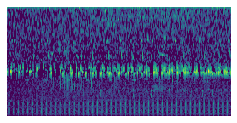

1it [00:08,  8.12s/it]

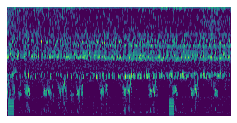

2it [00:15,  7.84s/it]

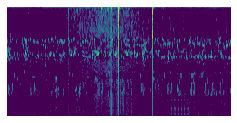

3it [00:24,  8.19s/it]

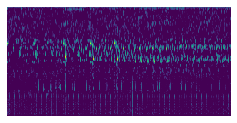

4it [00:32,  8.04s/it]

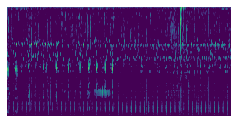

5it [00:38,  7.64s/it]

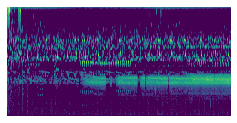

6it [00:45,  7.47s/it]

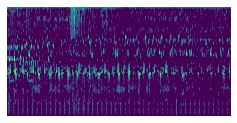

7it [00:52,  7.34s/it]

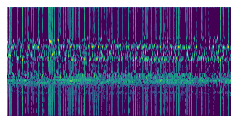

8it [01:00,  7.37s/it]

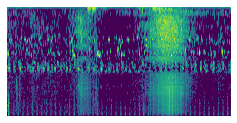

9it [01:07,  7.32s/it]

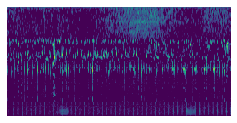

10it [01:14,  7.42s/it]


In [8]:
# Loop over 10 files and convert them to images
for index, row in tqdm(train_fp_noise.iloc[:10].iterrows()):
    # Get the Noise Interval
    recording_id = row['recording_id']
    t_min = row['t_min']
    
    # Load the train file
    fn = '%s.flac' % (recording_id)
    path = '../input/rfcx-species-audio-detection/train/' + fn
    save_image_from_sound(path, t_min)

# Future Work


Now I have denoised and converted the audio into images, the next step is to train the CNNs. After this I will test the CNN on the test set, and consider how to (possibly) denoise the test set samples.

Interesting Links:
- https://www.tensorflow.org/tutorials/images/cnn
- https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
